In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#from AI.Features.Segmenting import deep_segment
#from AI.Features.SegmentingV2 import deep_segment
from AI.Features.SegmentingV8 import deep_segment

#from AI.Features.Segmenting import restore_mask
from AI.Features.SegmentingV8 import restore_mask

from skimage import measure
import glob
import pandas as pd 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skimage import feature
import os

from random import sample


In [2]:
## Augmentation Function

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
def augm(lst, nm=5):
    # prepare iterator
    ls_gen=[]
    for arr in lst:

        data = arr
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.8,1],
                                     #rotation_range=50,
                                     width_shift_range=[0,.1],
                                     height_shift_range=[0,.1],
                                    #vertical_flip =True,
                                    #horizontal_flip=True
                                    ) 
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot

        for i in range(nm):
            # define subplot
            #pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            ls_gen.append(image)
    return lst+ls_gen

lymph= 5524
neut= 5860
MONO= 409
BASO= 85
EOSI= 596
[5524, 5860, 409, 85, 596]
12474


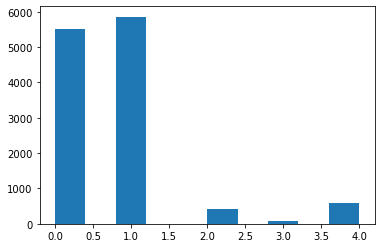

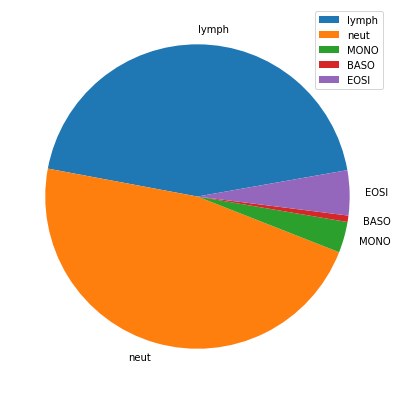

In [3]:
path1='./samples/Experiment/Training/*/*/' 
#path1='./samples/Experiment/Experiment/*/'    
    
path2='.\samples\Experiment3\Train\\'
#lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path2+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#MONO=augm(MONO, nm=3)

#lymph=sample(lymph,574)


ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


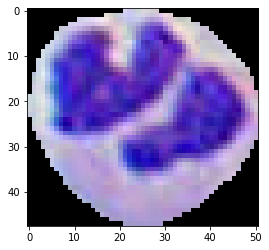

In [4]:
def get_nuc_and_cyt(segmented):
    nuc = (segmented==2).astype('uint8')
    cyt = (segmented==1).astype('uint8')
    #cyt,nuc=restore_mask(segmented)
    return cyt,nuc
     
def mask_cell(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(cyt)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im

img=mask_cell(neut[150])
plt.imshow(img)
plt.show()

In [5]:
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte
def GLCM(c):
    img =c# io.imread('ff.jpg')

    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    #io.imshow(image)

    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    # GLCM properties
    def contrast_feature(matrix_coocurrence):
        contrast = greycoprops(matrix_coocurrence, 'contrast')
        return "Contrast = ", contrast

    def dissimilarity_feature(matrix_coocurrence):
        dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')    
        return "Dissimilarity = ", dissimilarity

    def homogeneity_feature(matrix_coocurrence):
        homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
        return "Homogeneity = ", homogeneity

    def energy_feature(matrix_coocurrence):
        energy = greycoprops(matrix_coocurrence, 'energy')
        return "Energy = ", energy

    def correlation_feature(matrix_coocurrence):
        correlation = greycoprops(matrix_coocurrence, 'correlation')
        return "Correlation = ", correlation
   
    def ASM_feature(matrix_coocurrence):
        ASM = greycoprops(matrix_coocurrence, 'ASM')
        return "ASM = ", ASM

    
    f1=contrast_feature(matrix_coocurrence)[1][0].tolist()
    f2=dissimilarity_feature(matrix_coocurrence)[1][0].tolist()
    f3=homogeneity_feature(matrix_coocurrence)[1][0].tolist()
    f4=energy_feature(matrix_coocurrence)[1][0].tolist()
    f5=correlation_feature(matrix_coocurrence)[1][0].tolist()
    f6=ASM_feature(matrix_coocurrence)[1][0].tolist()

    return  np.array(f1+f2+f3+f4+f5+f6)
    
GLCM(mask_cell(neut[0]))

array([6.49568627, 9.4552    , 6.20470588, 8.3736    , 1.08627451,
       1.5072    , 1.06039216, 1.364     , 0.7018056 , 0.62900716,
       0.70799823, 0.65859299, 0.2609426 , 0.23709779, 0.26263152,
       0.24201289, 0.85920042, 0.79367309, 0.86543405, 0.81729294,
       0.06809104, 0.05621536, 0.06897532, 0.05857024])

In [6]:
import numpy as np
from skimage.transform import integral_image
from skimage.feature import haar_like_feature

def haar(c):
    img = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)  
    img_ii = integral_image(img)
    feature = haar_like_feature(img_ii, 0, 0, 5, 5, 'type-3-x')
    return feature

len(haar(lymph[400]))

42

In [7]:
from skimage.feature import shape_index
def index_shape(c):
    image = color.rgb2gray(c)
    #image = img_as_ubyte(image)
    image=cv2.resize(image,(100,100))
    s = shape_index(image, sigma=0.1)
    return np.nan_to_num(s)[0] #np.floor(s)[0]
len(index_shape(lymph[200]))

C:\Users\DELL\anaconda3\lib\site-packages\skimage\feature\corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


100

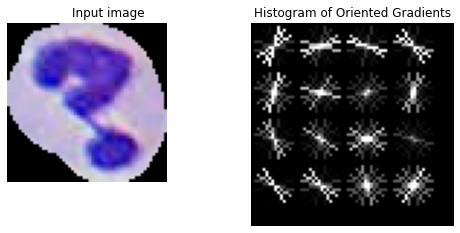

[0.51451689 0.51451689 0.51451689 0.32348424 0.29951909 0.02202374
 0.05846547 0.08694891 0.37346992 0.36703364 0.48222133 0.48222133
 0.48222133 0.05023887 0.14587816 0.06625638 0.3227237  0.06090787
 0.07452941 0.34508604 0.61044023 0.61044023 0.1217506  0.08603994
 0.1635024  0.0048944  0.02156864 0.09187009 0.55948241 0.55948241
 0.55948241 0.15898429 0.38807615 0.38807615 0.38807615 0.03649024
 0.36821584 0.33176809 0.38807615 0.38807615 0.29540081 0.41698093
 0.41698093 0.41698093 0.41698093 0.37438627 0.24092614 0.13796912
 0.35943456 0.35943456 0.35943456 0.35943456 0.35943456 0.35943456
 0.35943456 0.30926943 0.42394723 0.42394723 0.4152726  0.11072205
 0.10219362 0.2931224  0.42394723 0.42394723 0.35275561 0.05812578
 0.1032344  0.10216376 0.46127272 0.46127272 0.46127272 0.46127272
 0.4148308  0.34358607 0.30746903 0.10853024 0.29545595 0.4148308
 0.4148308  0.4148308  0.31827925 0.38148988 0.38148988 0.38148988
 0.38148988 0.38148988 0.38148988 0.15965951 0.38973791 0.34163

128

In [8]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

def HOG_im(c):
    image = mask_cell(c)
    #plt.imshow(image)
    #plt.show()
    #image=c
    image=cv2.resize(image,(70,70))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True,feature_vector=True)

    
    return fd,hog_image

ind=153
image=neut[ind]
fd,hog_image=HOG_im(image)

image=mask_cell(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
print(fd)
len(fd)
 

# Extent feature

In [9]:

def get_extent(nuc, cyt):
    
    # We only use the nucleus
    extent = measure.regionprops(nuc)[0]['extent']
    
    return extent


def all_together(cell):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    extent = get_extent(nuc,cyt)
    return extent
all_together(neut[150])




0.5663915978994749

In [10]:

def get_extent_cyt(nuc, cyt):
    
    # We only use the nucleus
    extent = measure.regionprops(cyt)[0]['extent']
    return extent

def all_together_cyt(cell):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    extent = get_extent_cyt(nuc,cyt)
    return extent


all_together_cyt(neut[150])
len(mask_cell(neut[150]))

48

In [12]:
def size1(cell,p):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    if p==0:return nuc.sum()
    if p==1:return cyt.sum()
    if p==2:return cyt.sum()+nuc.sum()

def peri(cell,p):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    ar=cyt
    if p==0:ar=nuc
    return measure.perimeter(ar, neighbourhood=8)

peri(MONO[150],1),size1(MONO[109],2)

(328.0, 4246)

In [13]:
#'eccentricity', 'solidity', 'extent', 'circularity', 'nuc_cyto_ratio', 'size', 'tortuosity'
from skimage import morphology

def eccentricity(im_part):
    if im_part.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(im_part)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,im_part.shape[0]-1,im_part.shape[1]-1)
    
    #tb=measure.regionprops(im_part)[0]['bbox']
    
    xb=abs(tb[1]-tb[3])
    xs=abs(tb[0]-tb[2])
    if xs>xb:
        tm=xb
        xb=xs
        xs=tm
    return np.sqrt(xb**2-xs**2)/xs
    
def Solidity(im_part):
    conv=morphology.convex_hull.convex_hull_image(im_part)  
    """
    print(im_part.sum())
    print(conv.sum())
    plt.imshow(im_part)
    plt.show()
    plt.imshow(conv)
    plt.show()
    """ 
    return im_part.sum()/conv.sum()

def circularity(im_part):
    pr=measure.perimeter(im_part, neighbourhood=8)
    return (pr**2)/(4*np.pi*im_part.sum())

def Convexity(im_part):
    conv=morphology.convex_hull.convex_hull_image(im_part)  
    return measure.perimeter(conv)/measure.perimeter(im_part)

In [14]:
img=neut[13]
segmented = deep_segment(img)
cyt,nuc = get_nuc_and_cyt(segmented)
print(eccentricity(nuc),eccentricity(nuc+cyt))
print(Solidity(nuc),Solidity(nuc+cyt))
print(circularity(nuc),circularity(nuc+cyt))
print(Convexity(nuc),Convexity(nuc+cyt))

0.5532833351724882 0.7618452357699076
0.8483547925608012 0.9764150943396226
2.9558775079228488 1.5039256369991654
0.7802470883492426 1.0


In [15]:
def shape_features(image):
    segmented = deep_segment(image)
    cyt,nuc = get_nuc_and_cyt(segmented)
    all_cyt=nuc+cyt
    n_sum=nuc.sum()
    cyt_sum=all_cyt.sum()
    lst=[eccentricity(nuc),eccentricity(all_cyt),Solidity(nuc),Solidity(all_cyt),circularity(nuc),
         circularity(all_cyt),Convexity(nuc),Convexity(all_cyt)]
    lst.append(measure.perimeter(nuc, neighbourhood=8)/n_sum)
    lst.append(measure.perimeter(cyt, neighbourhood=8)/cyt_sum)
    lst.append(n_sum/cyt_sum)
    return np.array(lst)
    
img=neut[12]    
shape_features(img)    

array([1.00346621, 1.0930633 , 0.61821086, 0.96432681, 4.56511485,
       1.604844  , 0.72833873, 0.9947896 , 0.38501292, 0.25442376,
       0.46181384])

# LBP Feature Extraction

In [16]:


 
from skimage import feature
import numpy as np
class LocalBinaryPatterns:  
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
 

points=24  #24

obj=LocalBinaryPatterns(points,8)

v=obj.describe(mask_cell(neut[7]))
 
v



array([0.05405405, 0.07309582, 0.03685504, 0.01351351, 0.00798526,
       0.00675676, 0.00859951, 0.00859951, 0.00859951, 0.002457  ,
       0.00184275, 0.004914  , 0.0036855 , 0.002457  , 0.0036855 ,
       0.004914  , 0.00675676, 0.00798526, 0.00429975, 0.00614251,
       0.00184275, 0.00614251, 0.01167076, 0.01597052, 0.23341523,
       0.46375921])

#### Sum Of Edges (SOE)

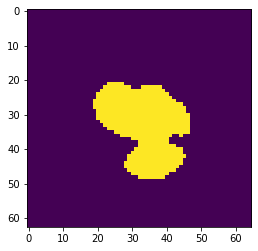

[2 4 2 2 2 1 1 1 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2]


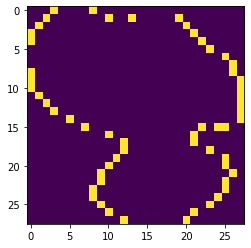

array([0.  , 0.45, 0.  , 0.11, 0.  ])

In [17]:
def edges1(im):
    for i in range(im.shape[0]-1):
        for j in range(im.shape[1]-1):
            if im[i,j]==0 and im[i,j+1]==1:
                im[i,j]=1
            elif im[i,j]==1 and im[i,j+1]==0:
                im[i,j]=1
            else:
                im[i,j]=0
    return im

def count_list(ls):
    ls2=[0,0,0,0,0]
    for x in ls:
        if x==1:
            ls2[0]=ls2[0]+1
        elif x==2:
            ls2[1]=ls2[1]+1
        elif x==3:
            ls2[2]=ls2[2]+1
        elif x==4:
            ls2[3]=ls2[3]+1
        elif x>4:
            ls2[4]=ls2[4]+1
    return ls2
        
def SOE(c):
    segmented = deep_segment(c)  
    cyt,nuc = get_nuc_and_cyt(segmented)
    
    if nuc.sum()!=0:
        tb=measure.regionprops(nuc)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,nuc.shape[0]-1,nuc.shape[1]-1)
    
    
    
    #tb=measure.regionprops(nuc)[0]['bbox']
    
    xv=abs(tb[1]-tb[3])
    xh=abs(tb[0]-tb[2])
    
    im=nuc.copy()
    im2=edges1(im)
    im=nuc.copy()
    im3=edges1(im.T)

    v2=im2.sum(axis=1)
    v3=im3.sum(axis=1)
    im_ls=v2.tolist()+v3.tolist()
    #cn=(xh+xv)/2
    freq=np.array(count_list(im_ls))
    return freq/100  #np.array([freq[3]/freq[1]]) #np.array([ freq[2]/freq[1],freq[3]/freq[1],freq[4]/freq[1] ])    #/100#cn #(len(v2)+len(v3))

#### Examples##################
ind=60
mmg=neut[ind]
segmented = deep_segment(mmg)  
cyt,nuc  = get_nuc_and_cyt(segmented)
plt.imshow(nuc)
plt.show()
tb=measure.regionprops(nuc)[0]['bbox']

imt=edges1(nuc)
imt=imt[tb[0]:tb[2],tb[1]:tb[3]] 
print(imt.sum(axis=1))
plt.imshow(imt)
plt.show()

SOE(mmg)  #np.divide

# LBP and Extent

In [18]:
obj=LocalBinaryPatterns(points,8)   #(58,4)
def LBP_and_extent(c):

    ss=obj.describe(mask_cell(c))
    ss=ss.tolist()
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
LBP_and_extent(lymph[-4])

array([5.19067797e-02, 4.09604520e-02, 1.16525424e-02, 3.53107345e-04,
       7.06214689e-04, 7.06214689e-04, 2.11864407e-03, 2.47175141e-03,
       7.06214689e-04, 7.06214689e-04, 2.82485876e-03, 7.06214689e-04,
       2.11864407e-03, 6.00282486e-03, 6.35593220e-03, 6.35593220e-03,
       5.29661017e-03, 7.41525424e-03, 8.12146893e-03, 7.06214689e-03,
       5.64971751e-03, 1.05932203e-03, 3.17796610e-03, 4.94350282e-03,
       5.19420904e-01, 3.01200565e-01, 3.71375978e-02])

In [18]:
obj=LocalBinaryPatterns(points,8)   #(58,4)
def SOE_LBP_and_extent(c):
    ss=obj.describe(mask_cell(c))
    ss=ss.tolist()
    s2=SOE(c)
    s2=s2.tolist()
    ss=ss+s2
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
SOE_LBP_and_extent(neut[7])

array([0.05405405, 0.07309582, 0.03685504, 0.01351351, 0.00798526,
       0.00675676, 0.00859951, 0.00859951, 0.00859951, 0.002457  ,
       0.00184275, 0.004914  , 0.0036855 , 0.002457  , 0.0036855 ,
       0.004914  , 0.00675676, 0.00798526, 0.00429975, 0.00614251,
       0.00184275, 0.00614251, 0.01167076, 0.01597052, 0.23341523,
       0.46375921, 0.        , 0.39      , 0.        , 0.23      ,
       0.        , 0.05306972])

### SOE+Extent 

In [19]:
obj=LocalBinaryPatterns(points,8)   #(58,4)
def SOE_and_extent(c):

    ss=SOE(c)
    ss=ss.tolist()
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
SOE_and_extent(lymph[4])

array([0.        , 0.58      , 0.        , 0.01      , 0.        ,
       0.07730415])

### Shape Features+ SOE

In [20]:

def shapef_and_SOE(c):

    ss=SOE(c)
    ss=ss.tolist()
    s2=shape_features(c)
    s2=s2.tolist()
    ss=ss+s2
    ss=np.array(ss)
    return ss
shapef_and_SOE(lymph[-4])

array([0.        , 0.8       , 0.        , 0.        , 0.        ,
       0.81916369, 0.7147382 , 0.68622449, 0.73864244, 2.27826258,
       2.91505752, 1.1691952 , 0.91228881, 0.18835192, 0.23401897,
       0.58393632])

### Shape Features+ SOE+Extent

In [21]:
def shapef_and_SOE_extent(c):

    ss=SOE(c)
    ss=ss.tolist()
    s2=shape_features(c)
    s2=s2.tolist()
    ss=ss+s2
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
shapef_and_SOE_extent(lymph[-4])

array([0.        , 0.8       , 0.        , 0.        , 0.        ,
       0.81916369, 0.7147382 , 0.68622449, 0.73864244, 2.27826258,
       2.91505752, 1.1691952 , 0.91228881, 0.18835192, 0.23401897,
       0.58393632, 0.0371376 ])

### Shape Features+ SOE+Extent+LBP

In [22]:
def shapef_and_SOE_extent_LBP(c):

    ss=SOE(c)
    ss=ss.tolist()
    s2=shape_features(c)
    s2=s2.tolist()
    s3=obj.describe(mask_cell(c))
    s3=s3.tolist()
    ss=ss+s2+s3
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
shapef_and_SOE_extent_LBP(lymph[-4])

array([0.00000000e+00, 8.00000000e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.19163689e-01, 7.14738200e-01, 6.86224490e-01,
       7.38642437e-01, 2.27826258e+00, 2.91505752e+00, 1.16919520e+00,
       9.12288815e-01, 1.88351921e-01, 2.34018968e-01, 5.83936324e-01,
       5.19067797e-02, 4.09604520e-02, 1.16525424e-02, 3.53107345e-04,
       7.06214689e-04, 7.06214689e-04, 2.11864407e-03, 2.47175141e-03,
       7.06214689e-04, 7.06214689e-04, 2.82485876e-03, 7.06214689e-04,
       2.11864407e-03, 6.00282486e-03, 6.35593220e-03, 6.35593220e-03,
       5.29661017e-03, 7.41525424e-03, 8.12146893e-03, 7.06214689e-03,
       5.64971751e-03, 1.05932203e-03, 3.17796610e-03, 4.94350282e-03,
       5.19420904e-01, 3.01200565e-01, 3.71375978e-02])

In [23]:
def shapef_extent(c):

    ss=shape_features(c)
    ss=ss.tolist()
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
shapef_extent(lymph[-4])

array([0.81916369, 0.7147382 , 0.68622449, 0.73864244, 2.27826258,
       2.91505752, 1.1691952 , 0.91228881, 0.18835192, 0.23401897,
       0.58393632, 0.0371376 ])

In [24]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

import cv2

model_url = ".\imagenet_efficientnet_v2_imagenet21k_s_feature_vector_2"
module = hub.KerasLayer(model_url)



In [25]:
def deepfeature(image):
    image = np.array(image)
    if len(image.shape)==2:
        backtorgb = cv2.cvtColor(np.array(image, dtype=np.uint8),cv2.COLOR_GRAY2RGB)
        image=backtorgb

    image=cv2.resize(image,(384,384))
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
    logits=module(image)
    return np.array(logits)[0]
 
image=lymph[10]
logits =deepfeature(image) # module(preprocess_image(image))
logits.shape
 

(1280,)

In [26]:
def shapef_GLCM(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    ss=ss+s2
    ss=np.array(ss)
    return ss
shapef_GLCM(lymph[-4])




array([ 0.81916369,  0.7147382 ,  0.68622449,  0.73864244,  2.27826258,
        2.91505752,  1.1691952 ,  0.91228881,  0.18835192,  0.23401897,
        0.58393632,  5.88748648,  7.60638298,  6.84806034, 10.21019809,
        0.74936891,  0.95267792,  0.82938218,  1.21093177,  0.82775665,
        0.79044461,  0.8220546 ,  0.7660082 ,  0.49999828,  0.48759472,
        0.5002425 ,  0.48239862,  0.85837974,  0.81621347,  0.83400207,
        0.75329833,  0.24999828,  0.23774861,  0.25024256,  0.23270843])

In [27]:
def shapef_GLCM_SOE(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    ss=ss+s2+s3
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE(lymph[-4])




array([ 0.81916369,  0.7147382 ,  0.68622449,  0.73864244,  2.27826258,
        2.91505752,  1.1691952 ,  0.91228881,  0.18835192,  0.23401897,
        0.58393632,  5.88748648,  7.60638298,  6.84806034, 10.21019809,
        0.74936891,  0.95267792,  0.82938218,  1.21093177,  0.82775665,
        0.79044461,  0.8220546 ,  0.7660082 ,  0.49999828,  0.48759472,
        0.5002425 ,  0.48239862,  0.85837974,  0.81621347,  0.83400207,
        0.75329833,  0.24999828,  0.23774861,  0.25024256,  0.23270843,
        0.        ,  0.8       ,  0.        ,  0.        ,  0.        ])

In [28]:
def shapef_GLCM_SOE_deep(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    s4=deepfeature(c)
    s4=s4.tolist()
    ss=ss+s2+s3+s4
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE_deep(lymph[-118])

array([ 0.44670626,  0.27467402,  0.97243108, ..., -0.11510147,
        0.21828589, -0.00422766])

In [29]:
def shapef_GLCM_SOE_HOG(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    s4=HOG_im(c)[0]
    s4=s4.tolist()
    ss=ss+s2+s3+s4
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE_HOG(lymph[-4])

array([8.19163689e-01, 7.14738200e-01, 6.86224490e-01, 7.38642437e-01,
       2.27826258e+00, 2.91505752e+00, 1.16919520e+00, 9.12288815e-01,
       1.88351921e-01, 2.34018968e-01, 5.83936324e-01, 5.88748648e+00,
       7.60638298e+00, 6.84806034e+00, 1.02101981e+01, 7.49368915e-01,
       9.52677916e-01, 8.29382184e-01, 1.21093177e+00, 8.27756652e-01,
       7.90444607e-01, 8.22054600e-01, 7.66008197e-01, 4.99998277e-01,
       4.87594720e-01, 5.00242501e-01, 4.82398617e-01, 8.58379740e-01,
       8.16213470e-01, 8.34002068e-01, 7.53298335e-01, 2.49998277e-01,
       2.37748611e-01, 2.50242560e-01, 2.32708426e-01, 0.00000000e+00,
       8.00000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.42168914e-01, 1.28029512e-01, 4.23515874e-01, 4.23515874e-01,
       4.23515874e-01, 4.23515874e-01, 3.47804025e-01, 2.94163628e-01,
       3.63010890e-01, 3.63010890e-01, 3.63010890e-01, 3.63010890e-01,
       2.78498931e-01, 3.63010890e-01, 3.63010890e-01, 3.63010890e-01,
      

In [30]:
def shapef_GLCM_SOE_HOG_deep(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    s4=HOG_im(c)[0]
    s4=s4.tolist()
    s5=deepfeature(c)
    #print(len(s4))
    s5=s5.tolist()
    ss=ss+s2+s3+s4+s5
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE_HOG_deep(lymph[1])

array([ 0.32868411,  0.27467402,  0.98019802, ..., -0.10538895,
        0.0512499 , -0.00244634])

In [31]:
#obj=LocalBinaryPatterns(points,8)

def features(c, f):
    if f==1:
        return all_together(c) 
    elif f==2:
        return obj.describe(mask_cell(c))
    elif f==3:
        return LBP_and_extent(c)
    elif f==4:
        return vggface3(c)
    elif f==5:
        return SOE_and_extent(c)
    elif f==6:
        return SOE_LBP_and_extent(c)
    elif f==7:
        return deepfeature(c)  95%
    elif f==8:
        return SOE(c)
    elif f==9:
        return shape_features(c)
    elif f==10:
        return shapef_and_SOE(c)    
    elif f==11:
        return shapef_and_SOE_extent(c)    
    elif f==12:
        return shapef_and_SOE_extent_LBP(c)  
    elif f==13:
        return shapef_extent(c)  
    elif f==14:
        return GLCM(mask_cell(c))
    elif f==15:
        return shapef_GLCM(c)
    elif f==16:
        return shapef_GLCM_SOE(c)  92%
    elif f==17:
        return HOG_im(c)[0]    
    elif f==18:
        return shapef_GLCM_SOE_HOG(c)
    elif f==19:
        #PCA
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)  
    elif f==20:
        #lda
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)
    elif f==21:
        return shapef_GLCM_SOE_HOG_deep(c)
    elif f==22:
        return shapef_GLCM_SOE_deep(c)   
    elif f==23:
        return haar(c)
    elif f==24:
        return index_shape(c)
    elif f==25:
        return peri(c,1)
    elif f==26:
        return peri(c,0)
    elif f==27:
        return size1(c,2)
    elif f==28:
        return size1(c,0)    
    elif f==29:
        return [size1(c,0),size1(c,2),peri(c,0),peri(c,1)]
    elif f==30:
        return [size1(c,0),size1(c,2),peri(c,0),peri(c,1)]+list(deepfeature(c)) 

In [32]:

def alldata(cls,ft):

    if cls==2:
        lymph_extent = [ features(c, ft) for c in lymph]
        MONO_extent = [features(c, ft) for c in MONO]
        x = np.array(lymph_extent + MONO_extent)#
        if ft==1 or ft==25 or ft==26 or ft==27 or ft==28  : x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(MONO_extent)*[1]

    
    elif cls==3:
        neut_extent = [features(c, ft) for c in neut]
        lymph_extent = [features(c, ft) for c in lymph]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(MONO_extent)*[2]
        
    elif cls==5:
        neut_extent = [features(c, ft)  for c  in neut]
        lymph_extent = [features(c, ft)  for c  in lymph]
        BASO_extent = [ features(c, ft)  for c  in BASO]
        EOSI_extent = [ features(c, ft)  for c in EOSI]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ BASO_extent+ EOSI_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(BASO_extent)*[2]+len(EOSI_extent)*[3]+len(MONO_extent)*[4]
        
    return x,y

In [33]:



def classif(cls,ft):
    print('#########################################################################################')
    print()
    print("classes=",cls,'   Features type=',ft)
    print()
    
    if ft==19:  pca = PCA(n_components=50)
    if ft==20:  lda = LinearDiscriminantAnalysis(n_components=4)
        
    x,y=alldata(cls,ft)
    
    print('training length=',len(x))
    print()
    print('#########################################################################################')    
    names = ["Decision Tree","Nearest Neighbors", "Neural Net", "AdaBoost", "SVM", "GaussianNB",
             "Random Forest"]

    classifiers = [tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1),
                   KNeighborsClassifier(7),
                   MLPClassifier(alpha=.1, max_iter=10000),
                   AdaBoostClassifier(),
                   SVC(gamma=2, C=1),
                   GaussianNB(),
                   RandomForestClassifier(max_depth=1, n_estimators=10, max_features=1)
                   ]
    #classifiers=[MLPClassifier(alpha=.1, max_iter=10000)]
    rkf=RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)
    y1=np.array(y)
    for name, clf in zip(names, classifiers):
        list1=[]
        list_tr=[]
        for train, test in rkf.split(x):
            #print("%s %s" % (train, test),"\n")
            #print(y1[train])
            X_train, X_test, y_train, y_test=x[train], x[test], y1[train], y1[test]
            
            if ft==19: #PCA
                #X_train = StandardScaler().fit_transform(X_train)
                #X_test = StandardScaler().fit_transform(X_test)
                X_train=pca.fit_transform(X_train)
                X_test= pca.transform(X_test)
                
            if ft==20: #LDA
                #X_train = StandardScaler().fit_transform(X_train)
                #X_test = StandardScaler().fit_transform(X_test)
                X_train=lda.fit_transform(X_train,y_train)
                X_test= lda.transform(X_test)
                
            clf.fit(X_train, y_train)
            predictions=clf.predict(X_test)
            #list.append(accuracy_score(y_test, predictions))
            list1.append(f1_score(y_test, predictions,average='macro'))
            
            list_tr.append(accuracy_score(y_train, clf.predict(X_train)))

        print()
        print(name)
        #print(list_tr,"\n")
        print("Training Accuracy",end=" : ")
        print("\t",np.array(list_tr).mean(),"\t\terror +/-=",np.array(list_tr).std())

        #print(list,"\n")
        print("Test Accuracy",end=" : ")
        print("\t",np.array(list1).mean(),"\t\terror +/-=",np.array(list1).std())

In [35]:
for cls in [2]: 
    for ft in [7]:#[1,2,3]:
        classif(cls,ft)

#########################################################################################

classes= 2    Features type= 7

training length= 7661

#########################################################################################

Decision Tree
Training Accuracy : 	 0.8131466006219193 		error +/-= 0.039259807244424114
Test Accuracy : 	 0.6448693772959063 		error +/-= 0.03529594547645313

Nearest Neighbors
Training Accuracy : 	 0.9642344253236544 		error +/-= 0.0008050851502187677
Test Accuracy : 	 0.801819266968182 		error +/-= 0.01866255613472634

Neural Net
Training Accuracy : 	 1.0 		error +/-= 0.0
Test Accuracy : 	 0.89242852326102 		error +/-= 0.007864385634016327

AdaBoost
Training Accuracy : 	 0.9779401057515348 		error +/-= 0.0025405499648192826
Test Accuracy : 	 0.8421064150507993 		error +/-= 0.013233317634631923

SVM
Training Accuracy : 	 1.0 		error +/-= 0.0
Test Accuracy : 	 0.7548713169737189 		error +/-= 0.012688845842038667

GaussianNB
Training Accuracy : 	 0.7854

In [ ]:
##########################################################################################

lymph= 5524
neut= 5860
MONO= 409
BASO= 85
EOSI= 596
[5524, 5860, 409, 85, 596]
12474


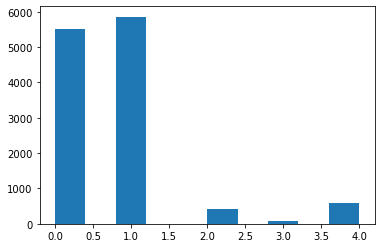

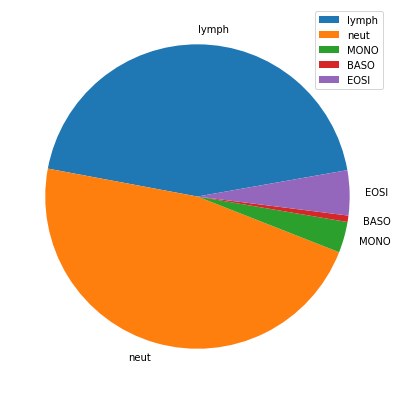

In [34]:
path1='./samples/Experiment/Training/*/*/'      
path2='.\samples\Experiment3\Train\\'
#lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path2+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#MONO=augm(MONO,nm=5)

#lymph=sample(lymph,4574)

ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


In [35]:
cl=2
fe=7

x,y=alldata(cl,fe)
X_train=x
y_train=y


In [36]:
from sklearn.neural_network import MLPClassifier
#cls =  MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)
cls =MLPClassifier(alpha=.1, max_iter=10000)
#cls=KNeighborsClassifier(7)
cls.fit(X_train,y_train)


MLPClassifier(alpha=0.1, max_iter=10000)

In [37]:
path1='./samples/Experiment/Experiment/*/'    
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]


ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]



In [90]:
len(lymph)

2583

In [38]:
#cl=5
#fe=1
x2,y2=alldata(cl,fe)
X_test=x2
y_test=y2

In [54]:
X_test.shape

(2935, 1280)

In [55]:
cls.score(X_test,y_test)

0.9233390119250426

In [41]:
predictions=cls.predict(X_test)


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions , target_names=["lymph","MONO"]))

              precision    recall  f1-score   support

       lymph       0.95      0.96      0.96      2583
        MONO       0.70      0.63      0.66       352

    accuracy                           0.92      2935
   macro avg       0.83      0.80      0.81      2935
weighted avg       0.92      0.92      0.92      2935



In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[2488,   95],
       [ 130,  222]], dtype=int64)

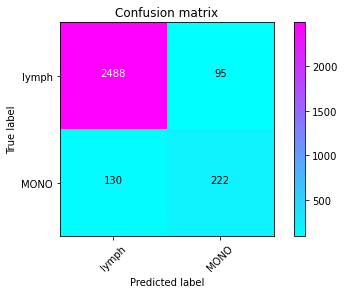

In [44]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Predict the values from the validation dataset
predictions = cls.predict(X_test)
# Convert predictions classes to one hot vectors 
#Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test , predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ["lymph" ,"MONO"])#range(5)



In [45]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def con_mat(Threshold=1):
    predictions = cls.predict_proba(X_test)*np.array([1,Threshold])
    predictions =predictions.argmax(axis=1)
    confusion_mtx = confusion_matrix(y_test , predictions)
    print(classification_report(y_test, predictions , target_names=["lymph","MONO"]))
    plot_confusion_matrix(confusion_mtx, classes = ["lymph" ,"MONO"])#range(5)



In [46]:

from ipywidgets import interactive, FloatSlider

interactive(lambda Threshold: con_mat(Threshold), Threshold=(0.0,100,1))

interactive(children=(FloatSlider(value=50.0, description='Threshold', step=1.0), Output()), _dom_classes=('wi…

In [51]:
with open('X_train.npy', 'wb') as f1:
    np.save(f1,X_train)
with open('y_train.npy', 'wb') as f1:
    np.save(f1,y_train)
with open('X_test.npy', 'wb') as f1:
    np.save(f1,X_test)
with open('y_test.npy', 'wb') as f1:
    np.save(f1,y_test)

In [2]:
with open('X_train.npy', 'rb') as f1:
    X_train=np.load(f1)
with open('y_train.npy', 'rb') as f1:
    y_train=np.load(f1)
with open('X_test.npy', 'rb') as f1:
    X_test=np.load(f1)
with open('y_test.npy', 'rb') as f1:
    y_test=np.load(f1)


In [3]:
dic={0:[1,0],1:[0,1]}
y_train=np.array([dic[x]  for x in y_train] )
y_test=np.array([dic[x]  for x in y_test] )

In [4]:
class_weight = {0: 1,1: 1}

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(5, input_dim=X_train.shape[1], activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(5, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'softmax'))


#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile('sgd',loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=16,  validation_data = (X_test, y_test))#class_weight=class_weight)

Epoch 1/10
371/371 [==============================] - 2s 4ms/step - loss: 0.4485 - accuracy: 0.8760 - val_loss: 0.2518 - val_accuracy: 0.8988
Epoch 2/10
371/371 [==============================] - 1s 1ms/step - loss: 0.1834 - accuracy: 0.9550 - val_loss: 0.2256 - val_accuracy: 0.9175
Epoch 3/10
371/371 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.9593 - val_loss: 0.2132 - val_accuracy: 0.9254
Epoch 4/10
371/371 [==============================] - 1s 1ms/step - loss: 0.1279 - accuracy: 0.9659 - val_loss: 0.2120 - val_accuracy: 0.9223
Epoch 5/10
371/371 [==============================] - 1s 2ms/step - loss: 0.1331 - accuracy: 0.9660 - val_loss: 0.2062 - val_accuracy: 0.9261
Epoch 6/10
371/371 [==============================] - 1s 2ms/step - loss: 0.1209 - accuracy: 0.9667 - val_loss: 0.2378 - val_accuracy: 0.9175
Epoch 7/10
371/371 [==============================] - 1s 2ms/step - loss: 0.1164 - accuracy: 0.9681 - val_loss: 0.2664 - val_accuracy: 0.8842
Epoch 

In [5]:
train_nan=np.isnan(X_train).sum()
if train_nan!=0: X_train[np.isnan(X_train)] = 0
    
test_nan=np.isnan(X_test).sum()
if test_nan!=0: X_test[np.isnan(X_test)] = 0


#clf.fit(X_train, y_train)


#predictions=clf.predict(X_test)
predictions=model.predict(X_test)

In [6]:
predictions=predictions*[1,1]
print(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

0.9240204429301533


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1) , target_names=["lymph","MONO"]))

              precision    recall  f1-score   support

       lymph       0.95      0.96      0.96      2583
        MONO       0.70      0.63      0.67       352

    accuracy                           0.92      2935
   macro avg       0.83      0.80      0.81      2935
weighted avg       0.92      0.92      0.92      2935



In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[2490,   93],
       [ 130,  222]], dtype=int64)

In [9]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def con_mat(Threshold=1):
    predictions = model.predict_proba(X_test)*np.array([1,Threshold])
    predictions =predictions.argmax(axis=1)
    print(y_test[0])
    confusion_mtx = confusion_matrix(y_test.argmax(axis=1) , predictions)
    print(classification_report(y_test.argmax(axis=1), predictions , target_names=["lymph","MONO"]))
    plot_confusion_matrix(confusion_mtx, classes = ["lymph","MONO"])#range(5)


In [10]:
from ipywidgets import interactive, FloatSlider

interactive(lambda Threshold: con_mat(Threshold), Threshold=(0.0,10,.1))

interactive(children=(FloatSlider(value=5.0, description='Threshold', max=10.0), Output()), _dom_classes=('wid…